We will (mostly) replicate the following paper: https://arxiv.org/abs/1710.06071

This paper works to establish a model capable of taking the abstract of a PubMed RCT paper, and splitting the sentences into groups to make the paragraph easier to read. 

# Get the Data

The data has been graciously made freely available on the author's (Frank Dernoncourt's) GitHub.

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-01ba01ca-8e1b-81a8-b6c6-d1b777d5ad39)


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


The following files contain the data:
```
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
```

There are 20k and 200k datasets along with seperate files for each where some preprocessing has already been done: the numbers have been replaced with `@`s.

We will concern ourselves with the 20k dataset for now with the number preprocessing dealt with, so we can establish a strong model first.

In [3]:
# Check what files are in the 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# Establish paths to all these files
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

import os
filenames = [data_dir + fname for fname in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Visualize and Preprocess Data

In [5]:
# Must be able to read in the contents of the files first
def get_lines(filename):
  """Reads in the content of a file at the specified path and returns the lines as a list"""
  with open(filename, 'r') as f:
    return f.readlines()

In [6]:
# Read in the lines from the training set
train_lines = get_lines(data_dir + "train.txt")
print(f"Total number of lines in the training set: {len(train_lines)}\n")
print(f"The first 20 lines:\n")
train_lines[:20]

Total number of lines in the training set: 210040

The first 20 lines:



['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

The data is not organized at all. One way to make everything neater is to represent the whole thing as a **list of dictionaries**, where each dictionary contains certain bits of information regarding the abstract it belongs to.

Since there are over 200000 lines, we should expect around 200000 dictionaries in the list.

In [7]:
# Write a preprocessing function to handle the above steps for us
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data"""
  # Read in the file first and get the lines
  input_lines = get_lines(filename)
  
  abstract_lines = "" # Create an empty abstract
  abstract_samples = [] # Create an empty list to append the dictionaries to 

  # Loop through each line that was read in 
  for line in input_lines:
    # If the line starts with ###, we've hit a new abstract
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = "" # Reset the abstract reader

    # If there is an empty line, the abstract is over
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # Abstract split into seperate lines

      for i, abstract_line in enumerate(abstract_line_split):
        # Extract the data for the line
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data["line_number"] = i
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"] = len(abstract_line_split) - 1 # Zero-indexed

        # Append the line dict to the list
        abstract_samples.append(line_data)        
    
    # Else we start to read everything in
    else:
      abstract_lines += line
    
  return abstract_samples

In [8]:
# Run this for the training, validation and test sets
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(f"""
Number of Training samples: {len(train_samples)}
Number of Validation samples: {len(val_samples)}
Number of Test samples: {len(test_samples)}
""")


Number of Training samples: 180040
Number of Validation samples: 30212
Number of Test samples: 30135

CPU times: user 449 ms, sys: 84.2 ms, total: 533 ms
Wall time: 537 ms


In [9]:
# Check out the first two dicts inside the list
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

In [10]:
# Put it all inside a DataFrame for easy IO
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(7)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11


In [11]:
# Grab the sentences as a list of strings
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

print(f"""
Number of Training sentences: {len(train_sentences)}
Number of Validation sentences: {len(val_sentences)}
Number of Test sentences: {len(test_sentences)}
""")

# Check the first three sentences of the training set
train_sentences[:3]


Number of Training sentences: 180040
Number of Validation sentences: 30212
Number of Test sentences: 30135



['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .']

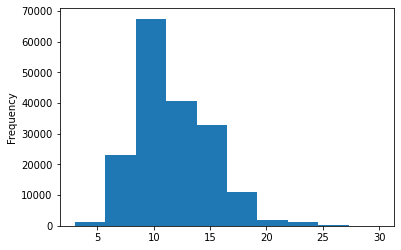

In [12]:
# What's the distribution of the total lines per abstract
train_df["total_lines"].plot.hist();

# Turning Labels to Numbers

We will make use of both Label and One-hot Encoding since they can come in useful later.

In [13]:
# One-hot encode the labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) # Sparse outputs not compatible with TensorFlow

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [14]:
# Now label encode them
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [15]:
train_labels_one_hot.shape, train_labels_encoded.shape

((180040, 5), (180040,))

# Preparing Data for Deep Sequence Modeling

We have the labels and the text. We can start by creating a Vectorizer and Token Embeddings for a deep model.

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.5.0


In [17]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

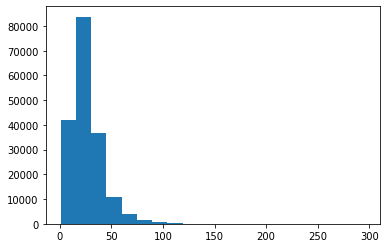

In [18]:
# Check the distribution of the sentence lengths
plt.hist(sent_lens, bins=20)

In [19]:
# What length of sentences describes 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [20]:
# Why does the graph go all the way to 300?
max(sent_lens)

296

Now that we have information regarding the distribution of sentence lengths, we can define better values to pass to our Vectorizer and Embedding layers.

## Text Vectorizer

In the paper, the cardinality of the 20k dataset was said to be around 68000, which means we can use this value for our Vectorizer's vocabulary.

In [21]:
# Create the Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000 # Size of vocab

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Define vocab size
                                    output_sequence_length=output_seq_len) # Truncate/Pad to 95th percentile length

# Adapt Vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [22]:
# Check if it works on a random sentence
import random
rand_sent = random.choice(train_sentences)

print(f"Original Text:\n{rand_sent}")
print(f"\nLength of Sentence: {len(rand_sent.split())}\n")
print(f"Vectorized input: {text_vectorizer([rand_sent])}")

Original Text:
secondary outcomes , domain-specific sitting over the whole day , were assessed by self-report .

Length of Sentence: 15

Vectorized input: [[  151    75 23344  2875   145     2  1300   108     9   113    22  2062
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [23]:
# Explore the Vectorizer a bit more
vectorizer_vocab = text_vectorizer.get_vocabulary()
print(f"""
Number of items in the Vocab: {len(vectorizer_vocab)}
5 common items in the Vocab: {vectorizer_vocab[:5]}
5 least common items in the Vocab: {vectorizer_vocab[-5:]}
""")


Number of items in the Vocab: 64841
5 common items in the Vocab: ['', '[UNK]', 'the', 'and', 'of']
5 least common items in the Vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



## Custom Token Embedding Layer

In [24]:
# Create the Embedding layer
token_embedding_layer = layers.Embedding(input_dim=len(vectorizer_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [25]:
# Check if the layer works
vectorized_sent = text_vectorizer([rand_sent])
embedded_sent = token_embedding_layer(vectorized_sent)
print(f"Sentence before Vectorization:\n{rand_sent}\n")
print(f"Sentence after Vectorization:\n{vectorized_sent}\n")
print(f"\nEmbedded Sentence:\n{embedded_sent}")

Sentence before Vectorization:
secondary outcomes , domain-specific sitting over the whole day , were assessed by self-report .

Sentence after Vectorization:
[[  151    75 23344  2875   145     2  1300   108     9   113    22  2062
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


Embedded Sentence:
[[[ 1.0662854e-02  6.0240999e-03 -4.9726773e-02 ...  3.9118979e-02
    1.8138740e-02  1.8286314e-02]
  [-4.1120123e-02 -3.4853172e-02 -2.0107675e-02 ... -1.6046382e-02
    7.8007691e-03  2.9024687e-02]
  [-4.0988494e-02  2.3384903e-02  1.4683757e-02 ...  8.6904541e-03
    7.1156770e-05 -1.0790825e-03]
  ...
  [-7.8444369e-03 -2.3250723e-02  2.2455480e-02 ... -4.7077835e-02
   -4.6716549e-02 -3.6198676e-02]
  [-7.8444369e-03 -2.3250723e-02  2.2455480e-02 ... -4.7077835e-02
 

In [26]:
# Check the shape
embedded_sent.shape

TensorShape([1, 55, 128])

# Pretrained Token Embedding Layer

The paper claims to use GloVe Token Embeddings from 2014. TensorFlow Hub has a pretrained model that suits the task almost perfectly: a BERT trained on PubMed extracts. We will see how this pretrained model (without fine-tuning) compares to the Custom Token Embeddings when we create our models later.

In [27]:
!pip3 install --quiet tensorflow-text
import tensorflow_hub as hub
import tensorflow_text as text 

# Load BERT Encoder and Preprocessing models as dictated by TF Hub
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

     |████████████████████████████████| 4.3MB 9.6MB/s 


In [28]:
# Set them up as Keras layers
preprocess_layer = hub.KerasLayer(preprocess, name="preprocessing")
bert_layer = hub.KerasLayer(bert, trainable=False, name="BERT_encoder")

In [29]:
# Test it out on a random sentence
bert_pooled_output = bert(preprocess([rand_sent]), training=False)["pooled_output"]
bert_seq_output = bert(preprocess([rand_sent]), training=False)["sequence_output"]

bert_pooled_output.shape, bert_seq_output.shape

(TensorShape([1, 768]), TensorShape([1, 128, 768]))

## Creating Datasets and testing the Pretrained Token Embeddings

The paper goes on to form a multimodal model but since we have a very deep pretrained model for feature extraction, we should try it out in a proper model to establish a baseline.

Our Baseline will be a Convolution-based Sequence Model which uses the BERT pretrained Embeddings.

In [ ]:
# Form datasets (forget the Testing for now)
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Prefetch and Autotune to optimize for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

In [ ]:
num_classes = len(label_encoder.classes_)

# Set up a Convolutional Model
inputs = layers.Input(shape=(), dtype=tf.string, name="text")
processed_inps = preprocess_layer(inputs)
bert_sequence_output = bert_layer(processed_inps, training=False)["sequence_output"]
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(bert_sequence_output)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

baseline_model = tf.keras.Model(inputs, outputs)

# Compile the model
baseline_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [ ]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  109482241   preprocessing[1][0]              
                                                                 preprocessing[1][1]              
                                                                 preprocessing[1][2]              
______________________________________________________________________________________________

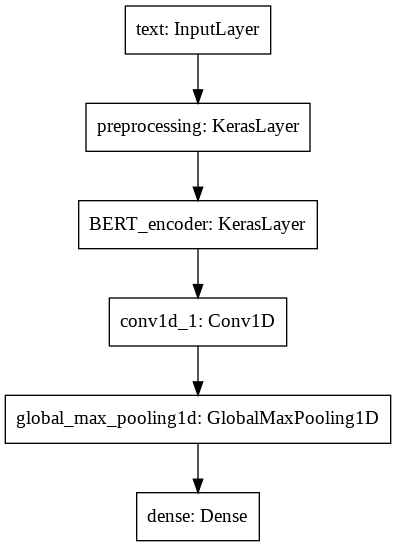

In [ ]:
# Make it more visual
from tensorflow.keras.utils import plot_model
plot_model(baseline_model)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c3e9541c-d921-7b79-bb5f-c920fd229d3d)


In [ ]:
# Fit the model
history_baseline = baseline_model.fit(train_dataset,
                                      epochs=3,
                                      steps_per_epoch=int(0.1*len(train_dataset)),
                                      validation_data=val_dataset,
                                      validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 244s 372ms/step - loss: 0.7139 - accuracy: 0.7980 - val_loss: 0.6773 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 219s 390ms/step - loss: 0.5316 - accuracy: 0.8329 - val_loss: 0.4439 - val_accuracy: 0.8421
Epoch 3/3
562/562 [==============================] - 219s 390ms/step - loss: 0.4357 - accuracy: 0.8469 - val_loss: 0.4449 - val_accuracy: 0.8291


In [30]:
# Write functions for plotting loss curves and grabbing evaluation metrics
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """Plots the loss curves for a history object"""
  accuracy = history.history["accuracy"]
  loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  epochs = range(len(history.history["loss"]))

  plt.figure();
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_acc, label="validation_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure();
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """Returns a dictionary of different Classification Metric values"""
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  results = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }
  return results

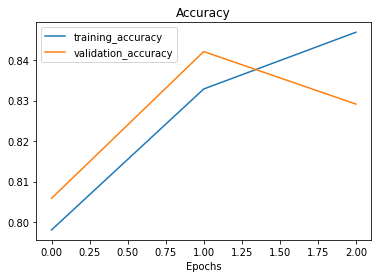

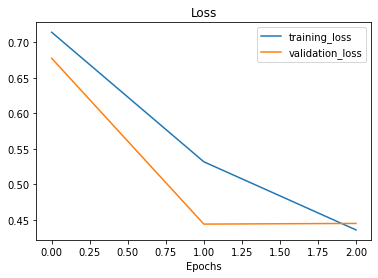

In [ ]:
# Check the loss curves for the baseline
plot_loss_curves(history_baseline)

In [ ]:
# Grab the predictions and the results
baseline_probs = baseline_model.predict(val_dataset, verbose=1)
baseline_preds = tf.argmax(baseline_probs, axis=1)
baseline_results = calculate_results(baseline_preds, val_labels_encoded)
baseline_results

945/945 [==============================] - 342s 362ms/step


{'accuracy': 0.8320865881106845,
 'f1': 0.8395819660138925,
 'precision': 0.8760295230145912,
 'recall': 0.8320865881106845}

In [ ]:
baseline_results

{'accuracy': 0.8320865881106845,
 'f1': 0.8395819660138925,
 'precision': 0.8760295230145912,
 'recall': 0.8320865881106845}

This is a very strong Baseline and highlights the power of Transfer Learning: particularly because the pretrained model was trained for an extensive period of time, on a much larger dataset, and its purposes are identical to our own task.

Safe to say, with such a strong baseline solely using Token Embeddings, there is no need to test out the custom Token Embeddings which would have to be trained from scratch on a much smaller dataset and with a much lower dimensionality.

# Character Embedding Layer

Along with pretrained GloVe Token Embeddings, the researchers also used Character Embeddings. The theory is that by coming up with richer representations for individual characters, the model should gain more insight into the use of language.

To actually prepare the Character Embedding layer, we need to split the textual inputs into their indivdual chars.

In [31]:
# Split sentences into chars
def split_chars(text):
  """Takes text and splits it into its individual characters"""
  return " ".join(list(text))

# Test it on a random sentence
split_chars(rand_sent)

's e c o n d a r y   o u t c o m e s   ,   d o m a i n - s p e c i f i c   s i t t i n g   o v e r   t h e   w h o l e   d a y   ,   w e r e   a s s e s s e d   b y   s e l f - r e p o r t   .'

In [32]:
# Prepare datasets for this type of embedding
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In deciding the hyperparameters for the Embedding layer, we should (same as before) explore the data to find good representative values.

In [33]:
# Find the average number of chars in a sentence
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

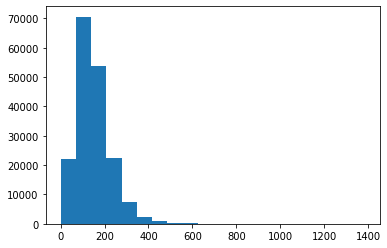

In [34]:
# Check the distribution
plt.hist(char_lens, bins=20)

In [35]:
# Check the 95th percentile
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

Note that since we do not have preprocessing for this section, we need to make another `Vectorizer` that numerically encodes the inputs for the `Embedding`. 

The size of the vocab this time will be much smaller: we aren't dealing with words anymore.

In [36]:
# Get a collection of ascii chars
import string
sample_chars = string.ascii_lowercase + string.digits + string.punctuation
sample_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
# Create the Vectorizer
num_char_tokens = len(sample_chars) + 2 # Extra space for whitespace and OOV tokens

char_vectorizer = TextVectorization(max_tokens=num_char_tokens,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [38]:
# Check out the Vectorizer
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of items inside Char-Vocab: {len(char_vocab)}\n")
print(f"Most common items in Char-Vocab: {char_vocab[:5]}")
print(f"Least common items in Char-Vocab: {char_vocab[-5:]}")

Number of items inside Char-Vocab: 28

Most common items in Char-Vocab: ['', '[UNK]', 'e', 't', 'i']
Least common items in Char-Vocab: ['k', 'x', 'z', 'q', 'j']


In [39]:
# Test it out on a sentence
random_chars = random.choice(train_chars)
print(f"Char-ified text:\n{random_chars}\n")
print(f"Length of char-ified text: {len(random_chars.split())}\n")
vectorized_chars = char_vectorizer([random_chars])
print(f"Vectorized Char Text:\n{vectorized_chars}\n")
print(f"Length of Processed chars: {len(vectorized_chars[0])}")

Char-ified text:
a   l a r g e r   p r a g m a t i c   t r i a l   i s   r e q u i r e d   t o   p r o v i d e   d e f i n i t i v e   e v i d e n c e   o f   e f f e c t i v e n e s s   a n d   c o s t - e f f e c t i v e n e s s   .

Length of char-ified text: 95

Vectorized Char Text:
[[ 5 12  5  8 18  2  8 14  8  5 18 15  5  3  4 11  3  8  4  5 12  4  9  8
   2 26 16  4  8  2 10  3  7 14  8  7 21  4 10  2 10  2 17  4  6  4  3  4
  21  2  2 21  4 10  2  6 11  2  7 17  2 17 17  2 11  3  4 21  2  6  2  9
   9  5  6 10 11  7  9  3  2 17 17  2 11  3  4 21  2  6  2  9  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [40]:
# Now for the Embedding layer
char_embedding_layer = layers.Embedding(input_dim=len(char_vocab),
                                        output_dim=25, # Specified by paper
                                        mask_zero=True,
                                        name="char_embedding")

In [41]:
# Test out the Embedding layer
sample = random.choice(train_chars)
vectorized_samp = char_vectorizer([sample])
embedded_samp = char_embedding_layer(vectorized_samp)
print(f"""
Original Char-ified text:\n{sample}\n
Chars after Vectorization and Embeddings:\n{embedded_samp}\n
Shape of Embedded Sample: {embedded_samp.shape}""")


Original Char-ified text:
t h e   w i l c o x o n   r a n k - s u m   t e s t   ,   u s i n g   t w o - s i d e d   a n a l y s i s   ,   w a s   u s e d   .

Chars after Vectorization and Embeddings:
[[[ 0.02375387  0.03799501  0.00606074 ... -0.04023597  0.01022015
   -0.00753293]
  [-0.01659568  0.01186943  0.04203974 ... -0.01616834 -0.04489453
    0.01744917]
  [-0.00690831 -0.03905838  0.0400951  ...  0.0187465   0.02641605
    0.04731693]
  ...
  [-0.02534236 -0.02015476 -0.00662319 ...  0.02255888 -0.01547077
   -0.02587024]
  [-0.02534236 -0.02015476 -0.00662319 ...  0.02255888 -0.01547077
   -0.02587024]
  [-0.02534236 -0.02015476 -0.00662319 ...  0.02255888 -0.01547077
   -0.02587024]]]

Shape of Embedded Sample: (1, 290, 25)


## Creating Datasets and testing the Pretrained Token with Character Embeddings

Let's test out whether Character Embeddings made a difference. We will not use a Convolution model this time so we can't really compare results but this is a good experiment to test against the baseline.

The choices for the `Dense` and `Bidirectional` layers are from replicating the paper's model.

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=(), dtype=tf.string, name="text")
processed_tok_inps = preprocess_layer(token_inputs)
bert_output = bert_layer(processed_tok_inps, training=False)["pooled_output"]
token_outputs = layers.Dense(128, activation="relu")(bert_output)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="chars")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_LSTM = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_LSTM)

# 3. Combine the two to form a hubrud Token Embedding
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Add in Dropout as specified by the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
last_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(last_dropout)

# 5. Construct the final model
token_char_model = tf.keras.Model(inputs=[token_model.input, char_model.input],
                                  outputs=output_layer,
                                  name="model_token_char_embeddings")

# Compile the model
token_char_model.compile(loss="categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(),
                         metrics=["accuracy"])

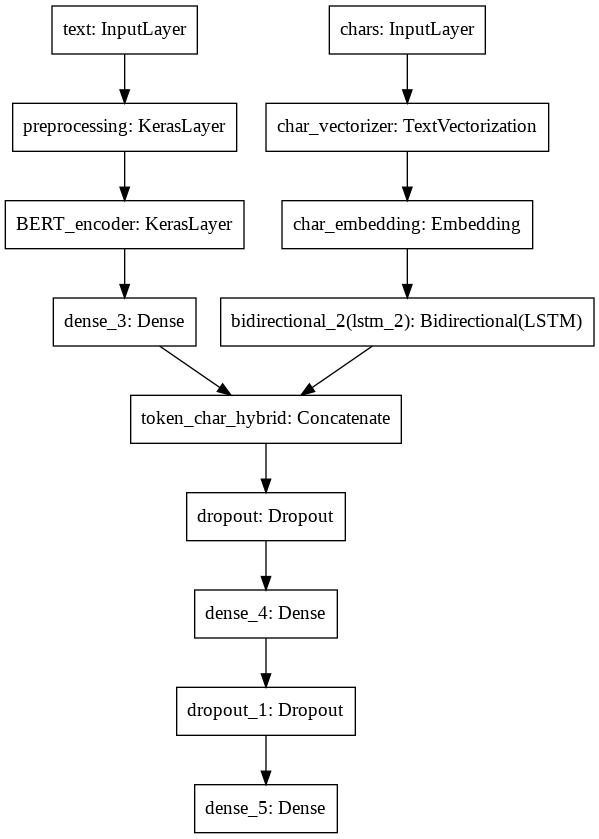

In [ ]:
# Visualize this champ
plot_model(token_char_model)

In [ ]:
token_char_model.summary()

Model: "model_token_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
chars (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           chars[0][0]                      
________________________________________________________________________

Since we dictated `inputs=[token_model.input, char_model.input]`, we need to form the `Dataset` keeping this order in mind.

On to making a `Dataset` accepting multiple streams.

In [ ]:
# Combine chars and tokens into a Dataset, then prefetch
train_token_char_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)
)
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_token_char_Dataset = tf.data.Dataset.zip(
    (train_token_char_data, train_token_char_labels)
)
train_token_char_Dataset = train_token_char_Dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Same steps for Validation Set
val_token_char_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars)
)
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_token_char_Dataset = tf.data.Dataset.zip(
    (val_token_char_data, val_token_char_labels)
)
val_token_char_Dataset = val_token_char_Dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_Dataset, val_token_char_Dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

Now to finally fit the model.

**Note:** This is the same model as that in the paper without Positional Embeddings.

In [ ]:
# Fit the Hybrid model
history_token_char_model = token_char_model.fit(train_token_char_Dataset,
                                                epochs=3,
                                                steps_per_epoch=int(0.1*len(train_token_char_Dataset)),
                                                validation_data=val_char_token_Dataset,
                                                validation_steps=int(0.1*len(val_char_token_Dataset)))

Epoch 1/3
562/562 [==============================] - 235s 402ms/step - loss: 0.7522 - accuracy: 0.7330 - val_loss: 0.4531 - val_accuracy: 0.8451
Epoch 2/3
562/562 [==============================] - 234s 416ms/step - loss: 0.5758 - accuracy: 0.8026 - val_loss: 0.4637 - val_accuracy: 0.8178
Epoch 3/3
562/562 [==============================] - 232s 414ms/step - loss: 0.5481 - accuracy: 0.8117 - val_loss: 0.4336 - val_accuracy: 0.8501


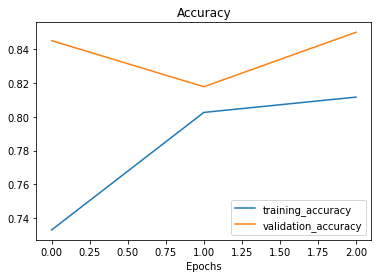

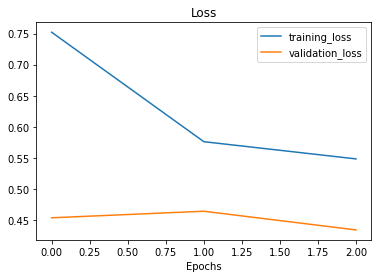

In [ ]:
# Plot the loss curves
plot_loss_curves(history_token_char_model)

In [ ]:
# Grab the predictions and evaluate
token_char_probs = token_char_model.predict(val_char_token_Dataset, verbose=1)
token_char_preds = tf.argmax(token_char_probs, axis=1)

945/945 [==============================] - 312s 328ms/step


In [ ]:
token_char_results = calculate_results(token_char_preds, val_labels_encoded)

In [ ]:
# Compare the Baseline to the Hybrid Embeddings model
print(f"""
Baseline Model Results:\n{baseline_results}\n
Hybrid Embeddings Model Results:\n{token_char_results}
""")


Baseline Model Results:
{'accuracy': 0.8320865881106845, 'precision': 0.8760295230145912, 'recall': 0.8320865881106845, 'f1': 0.8395819660138925}

Hybrid Embeddings Model Results:
{'accuracy': 0.8474778233814378, 'precision': 0.8524796547058978, 'recall': 0.8474778233814378, 'f1': 0.8483182648754471}



Seems we beat the Baseline that used fancy Convolution operations, with a Hybrid Embeddings model that used a `Bidirectional` layer in one of the streams and `Dense` layers everywhere else. It is not outlandish to say that we did benefit from the Character Embeddings.

# Positional Embeddings

The paper outlined that along with pretrained Token Embeddings and custom Character Embeddings, the final model made use of Positional Embeddings.

We will do the same since we did store positional information inside the `DataFrame` from earlier.

In [44]:
# Check the DataFrame
train_df.head(7)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11


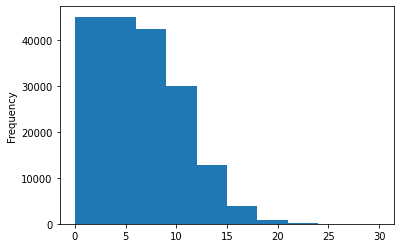

In [45]:
# Check the distribution of the line_number(s)
train_df["line_number"].plot.hist();

In [48]:
# Use percentiles to find a good value
np.percentile(train_df["line_number"], 95)

13.0

The majority of samples have `line_number` values below 15 which means we can One-Hot Encode these values with this depth. 

We do not label encode since we don't want the model to have any notion of hierarchy (like the length of the line) other than the order of the lines.

In [46]:
# One-Hot Encode the line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot.shape

TensorShape([180040, 15])

Now to also encode `total_lines`.

We also choose One-Hot Encoding here and have the depth equal to `20`.

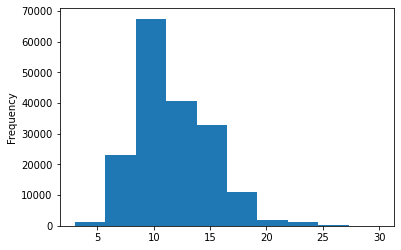

In [47]:
# Check the distribution of total_lines
train_df["total_lines"].plot.hist()

In [49]:
# Use percentiles to find a good value
np.percentile(train_df["total_lines"], 95)

18.0

In [51]:
# One-Hot Encode the total_lines col
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape

TensorShape([180040, 20])

# Constructing a Tribrid Model

Now to put everything together!

We will follow the procedure:
1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of (1) and (2) 
6. Combine the outputs of (3), (4) and (5) 
7. Create an output layer to accept the Tribrid Embedding and output prediction probabilities
8. Instantiate the model

In [52]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_inputs")
preprocessed_inputs = preprocess_layer(token_inputs)
bert_output = bert_layer(preprocessed_inputs, training=False)["pooled_output"]
token_outputs = layers.Dense(128, activation="relu")(bert_output)

token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding_layer(char_vectors)
char_bi_LSTM = layers.Bidirectional(layers.LSTM(24))(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_LSTM)

# 3. Line Numbers model
line_numbers_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_numbers_inputs)

line_number_model = tf.keras.Model(inputs=line_numbers_inputs,
                                   outputs=x)

# 4. Total Lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)

total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine Token and Char Embeddings with Dense and Dropout
combined_embeddings = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                    char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine Positional Embeddings with Hybrid Model
tribrid_embeddings = layers.Concatenate(name="positional_token_char_embeddings")([line_number_model.output,
                                                                                  total_lines_model.output,
                                                                                  z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put it all together
tribrid_model = tf.keras.Model(inputs=[line_number_model.input,
                                       total_lines_model.input,
                                       token_model.input,
                                       char_model.input],
                               outputs=output_layer,
                               name="tribrid_embedding_model")

# Check the summary
tribrid_model.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           token_inputs[0][0]               
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
____________________________________________________________________________

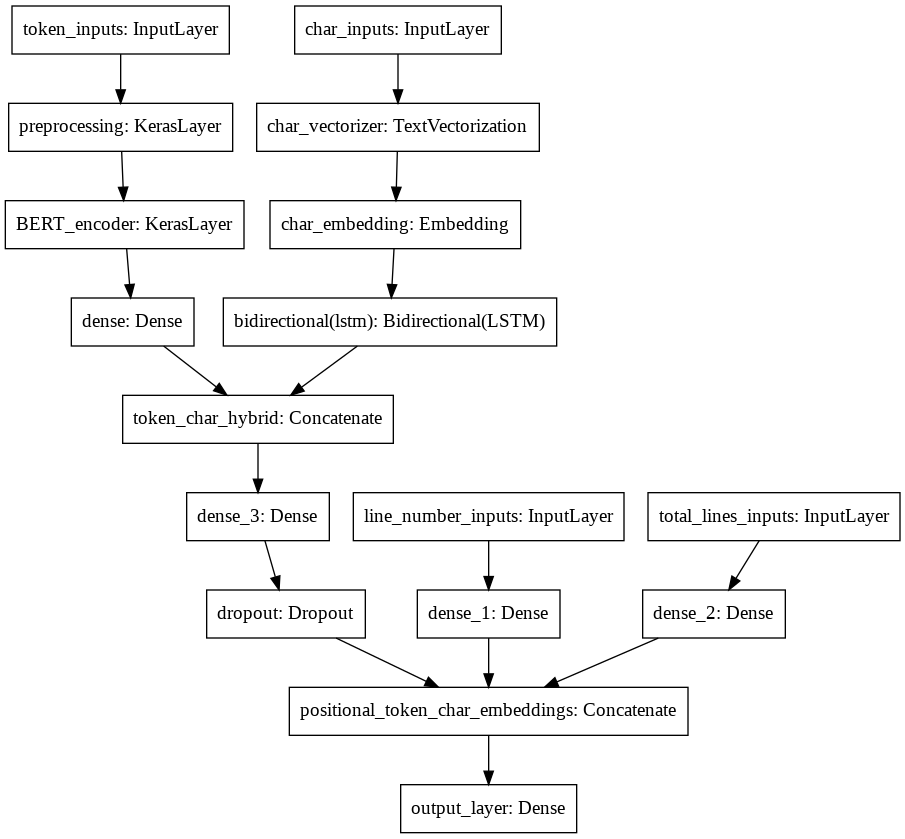

In [53]:
# The huge reveal
from tensorflow.keras.utils import plot_model
plot_model(tribrid_model)

Perfect!

When compiling the model, we will add **Label Smoothing** to try and reduce chances of Overfitting.

In [54]:
# Compile the model
tribrid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

## Creating Data Input Pipeline and fitting the Model

Now to create Prefetched Datasets and a appropriate callbacks to capture the best model we can during training.

In [55]:
# Zip the four inputs to form a Prefetched Dataset
train_pos_token_char_data = tf.data.Dataset.from_tensor_slices(
    (train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars)
)
train_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_pos_token_char_Dataset = tf.data.Dataset.zip(
    (train_pos_token_char_data, train_pos_token_char_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

# Same for the Validation data
val_pos_token_char_data = tf.data.Dataset.from_tensor_slices(
    (val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars)
)
val_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_pos_token_char_Dataset = tf.data.Dataset.zip(
    (val_pos_token_char_data, val_pos_token_char_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_token_char_Dataset, val_pos_token_char_Dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [56]:
# Instantiate ModelCheckpoint and EarlyStopping callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model_checkpoints.ckpt",
                                                      save_weights_only=True,
                                                      save_best_only=True)

In [58]:
# Fit the model on 20% of the data till it stops improving
STEPS_PER_EPOCH = int(0.2*len(train_pos_token_char_Dataset))
VALIDATION_STEPS = int(0.1*len(val_pos_token_char_Dataset))

history_tribrid_model = tribrid_model.fit(train_pos_token_char_Dataset,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_pos_token_char_Dataset,
                                          validation_steps=VALIDATION_STEPS,
                                          epochs=15,
                                          callbacks=[early_stopping, model_checkpoint])

Epoch 1/15
1125/1125 [==============================] - 438s 375ms/step - loss: 0.9431 - accuracy: 0.8373 - val_loss: 0.8638 - val_accuracy: 0.8803
Epoch 2/15
1125/1125 [==============================] - 421s 374ms/step - loss: 0.8808 - accuracy: 0.8736 - val_loss: 0.8538 - val_accuracy: 0.8780
Epoch 3/15
1125/1125 [==============================] - 421s 374ms/step - loss: 0.8742 - accuracy: 0.8777 - val_loss: 0.8482 - val_accuracy: 0.8820
Epoch 4/15
1125/1125 [==============================] - 425s 378ms/step - loss: 0.8646 - accuracy: 0.8819 - val_loss: 0.8466 - val_accuracy: 0.8900
Epoch 5/15
1125/1125 [==============================] - 424s 377ms/step - loss: 0.8630 - accuracy: 0.8812 - val_loss: 0.8897 - val_accuracy: 0.8471
Epoch 6/15
   2/1125 [..............................] - ETA: 1:45 - loss: 0.9024 - accuracy: 0.8250WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` b

1125/1125 [==============================] - 31s 27ms/step - loss: 0.9024 - accuracy: 0.8250 - val_loss: 0.8800 - val_accuracy: 0.8580


In [61]:
# Get the predictions
tribrid_probs = tribrid_model.predict(val_pos_token_char_Dataset, verbose=1)
tribrid_preds = tf.argmax(tribrid_probs, axis=1)
tribrid_preds[:5]

945/945 [==============================] - 296s 314ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 2, 2])>

In [62]:
# Evaluate
tribrid_results = calculate_results(val_labels_encoded,
                                    tribrid_preds)
tribrid_results

{'accuracy': 0.8614788825632199,
 'f1': 0.85833374996508,
 'precision': 0.8650365936794728,
 'recall': 0.8614788825632199}

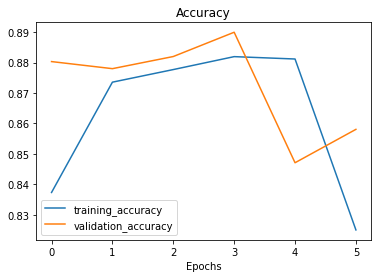

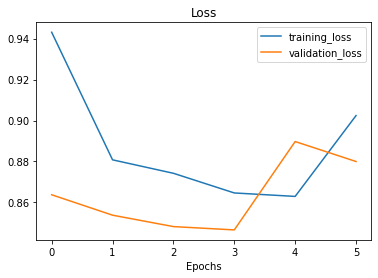

In [60]:
# Plot the loss curves
plot_loss_curves(history_tribrid_model)

# Comparing the Models

We only created three models:
* A Convolution-1D model with pretrained Token Embeddings trained for 3 epochs on 10% of the data
* A Hybrid model with pretrained Token and custom Character Embeddings trained for 3 epochs on 10% of the data
* A Tribrid model with pretraind Token and custom Character and Positional Embeddings trained on 20% of the data until it stopped improving

This really isn't a fair comparison but this way we can compare what happens when we really push our models.

In [63]:
# Put everything into a DataFrame
import pandas as pd
all_results = pd.DataFrame({
    "Conv1D_PretrainedToken": baseline_results,
    "Hybrid_Embeddings": token_char_results,
    "Tribrid_Embeddings": tribrid_results
}).transpose()

all_results

,accuracy,precision,recall,f1
Conv1D_PretrainedToken,0.832087,0.876030,0.832087,0.839582
Hybrid_Embeddings,0.847478,0.852480,0.847478,0.848318
Tribrid_Embeddings,0.861479,0.865037,0.861479,0.858334


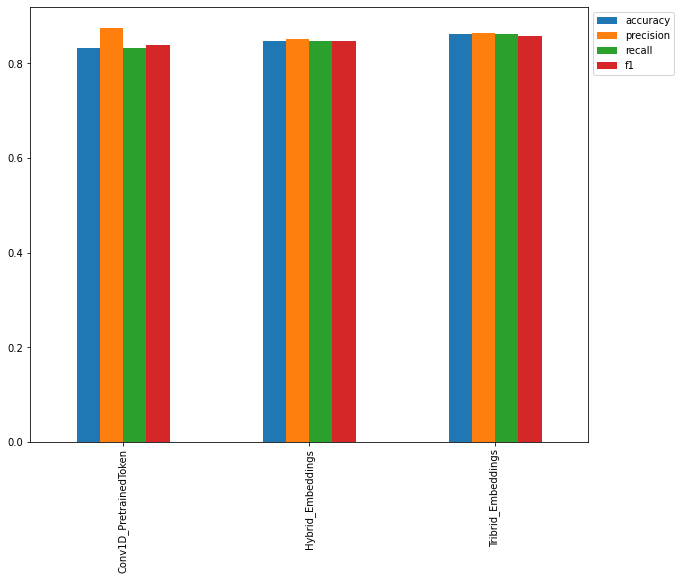

In [64]:
# Visualize the results
all_results.plot(kind="bar", figsize=(10,8)).legend(bbox_to_anchor=(1.0,1.0));

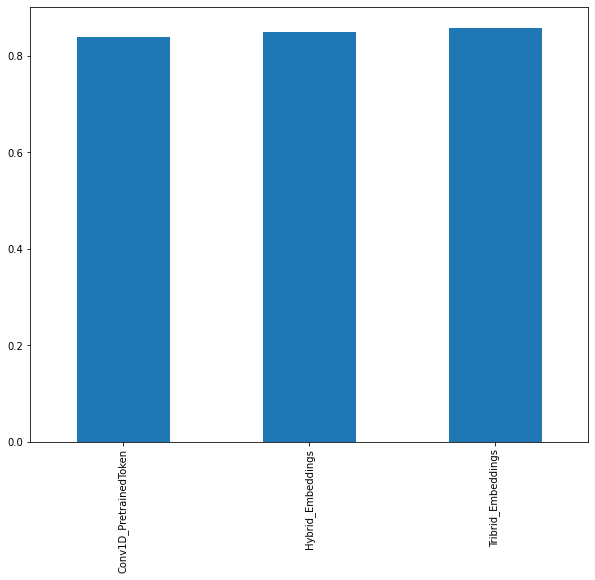

In [65]:
# A graphic for the F1 scores
all_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,8))

In [66]:
# Save the model to Google Drive
save_dir = "drive/MyDrive/models/SkimLit/RCT20k_6_Epochs20%"
os.makedirs(save_dir) # Make this directory if it doesn't already exist

# Save model
tribrid_model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/models/SkimLit/RCT20k_6_Epochs20%/assets


INFO:tensorflow:Assets written to: drive/MyDrive/models/SkimLit/RCT20k_6_Epochs20%/assets


While we did not beat the results in the aforementioned paper, it is likely that with more epochs and using a larger portion of the training set (provided there are no ERRORS during training), we can eventually beat the paper's benchmark.

# FIN